# SWASH 2D Willapa
## White Noise Test
A method to determine normal modes for the Willapa Bay is proposed, using SWASH 2D in a low-resolution configuration, with a white spectrum boundary condition at the estuary mouth. The thinking is that by forcing every frequency equally, the normal modes should "emerge" with a larger response. A bandpass for resonant frequencies can then reveal the shape of the modes. This proof-of-concept test ignores tides, which must be included in a complete model. 
### Bathymetry
I'll start by loading Willapa bay bathymetry from LiveOcean (model detailed here: https://faculty.washington.edu/pmacc/LO/LiveOcean.html )

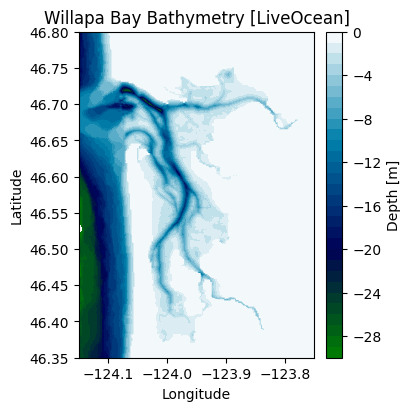

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

f = "/home/cassandra/Willapa/willapa_bathy_liveocean.nc"
nc = xr.open_dataset(f)

depth = -1*nc.h.values.flatten()
lats = nc.lat_rho.values.flatten()
lons = nc.lon_rho.values.flatten()
points = np.array([lons, lats])

plt.figure(figsize=(4,4), constrained_layout=True)
cf = plt.tricontourf(lons, lats, depth, levels=np.linspace(-30, 0, 31), cmap='ocean')
cb = plt.colorbar(cf)
cb.ax.set_ylabel("Depth [m]")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Willapa Bay Bathymetry [LiveOcean]")
plt.xlim(-124.15, -123.75)
plt.ylim(46.35, 46.8)
plt.show()

Note the bathymetry extends from 0 meters downwards. I need to adjust it for modeling purposes, by setting all 0 points (in LiveOcean, the minimum depth is actually -0.2) to a suitably high bathymetry, so I'm not modeling flows over the flattened land area. I will also re-project onto a UTM grid. 

Some decisions about the computational grid need to be made now. Because I'm interested in normal modes of the estuary, I don't necessarily want to resolve every wave. I'll start with 500 in the North (y) direction and 250 in the East (x) direction (around 20 meter pixels). 

What waves can this resolve? Assuming a wavelength 10 times the resolution, and a shallow water wave in 10 meters water depth, 
$$
\omega = k \sqrt{gh}
$$
or equivalently
$$
f = \sqrt{gh} / L
$$
Where $L = 200$ m, the resulting $f$ is a 40 second wave. However, in 1 meter depth, the frequency resolved is a 120 second wave -- well in the infragravity band!

SWASH developers recommend 50 grid cells per resolution, so I admit 10 is pushing it. But this is still a proof of concept. 

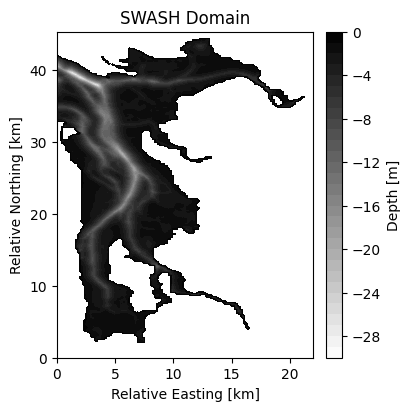

In [2]:
# First add 10 meters to all zero points on the bathy
depth[depth == -0.2] = 10

# Now get a UTM range for the model
import utm

# Convert a lat/lon bounding box to a UTM range
lat0, lon0 = 46.35, -124.05
x0, y0, _, __ = utm.from_latlon(lat0, lon0)
lat1, lon1 = 46.76, -123.77
x1, y1, _, __ = utm.from_latlon(lat1, lon1)

xrange = np.linspace(x0, x1, 250)
yrange = np.linspace(y0, y1, 500)

# Convert each lat/lon pair to utm
xs, ys = [], []
for lat, lon in zip(lats, lons):
    x, y, _, __ = utm.from_latlon(lat, lon)
    xs.append(x)
    ys.append(y)
xy = np.array([xs,ys]).T  # Convert to [N,2] shape

# Interpolate the unstructured bathy onto a grid
import scipy.interpolate
xx, yy = np.meshgrid(xrange, yrange)
zz = scipy.interpolate.griddata(xy, depth, (xx, yy))

# Get an x/y grid in problem coordinates
xp = xrange - xrange[0]
yp = yrange - yrange[0]

# Plot 
plt.figure(figsize=(4,4), constrained_layout=True)
cf = plt.contourf(xp/1000, yp/1000, zz, levels=np.linspace(-30, 0, 31), cmap='binary')
cb = plt.colorbar(cf)
cb.ax.set_ylabel("Depth [m]")
plt.xlabel("Relative Easting [km]")
plt.ylabel("Relative Northing [km]")
plt.title("SWASH Domain")
plt.show()

### Boundary Condition
I want a white spectrum of waves, in the frequencies I'm interested in (20 to 500 seconds), with low enough energy such that wave breaking/nonlinearity is minimal. I want a time series that is at least several periods for my smallest frequency, and with ample spinup time for waves to propagate into the domain. Let's say: 1 hour, at 1 Hz. 

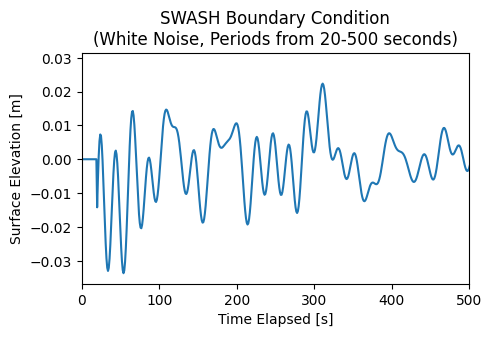

In [3]:
from scipy.fftpack import ifft, fftfreq, fftshift, fft

# Generate time stamp
dt = 1.0
t = np.arange(0, 3600, dt)

# Generate theoretical frequencies associated with fourier transforming the timestamps 
freq = fftfreq(len(t), d=dt)

# Generate theoretical fourier components.
# Magnitude = 1, but phase is random.
Fa = np.exp(np.random.rand(len(t))*2*np.pi)

# Set all frequencies outside our interest frequencies to 0
freq_of_interest = np.logical_and(np.abs(freq) > 1/500, np.abs(freq) < 1/20)
Fa[~freq_of_interest] = 0

# Inverse fft
a = np.real(ifft(Fa))

# Remove gibbs phenomena
a[:20] = 0
a[-20:] = 0

# Set significant wave height to like, 1 cm
a = a * 0.01 / np.std(a)  # Factor of 4 in numerator/denominator from Hsig cancels out

# Sanity plot first 500 seconds
plt.figure(figsize=(5,3))
plt.plot(t, a)
plt.xlim(0, 500)
plt.title("SWASH Boundary Condition\n(White Noise, Periods from 20-500 seconds)")
plt.xlabel("Time Elapsed [s]")
plt.ylabel("Surface Elevation [m]")
plt.show()

Why such a small wave height? In addition to minimizing nonlinearity (which is good -- the goal here is mostly to measure self-self resonances), a small wave height keeps the courant number very small, which means the timestep can be larger, and therefore the model runtime shorter. 

### Generating SWASH Input
I'll start by generating a directory and changing to that directory, to generate SWASH input files...

In [4]:
import os

def ensure_dir(path):
    dir = os.path.dirname(path)
    if not os.path.exists(dir):
        os.makedirs(dir)

ensure_dir('/home/cassandra/Willapa/SWASH2D-test/')
os.chdir('/home/cassandra/Willapa/SWASH2D-test/')

Next, I'll do the coordinates and bathy file. They need to be formatted carefully but this is easily done with pandas. 

In [5]:
import pandas as pd

# How many grid cells in x,y
mxc = len(xp) - 1
myc = len(yp) - 1

# I prefer things in problem coordinates
xx, yy = np.meshgrid(xp, yp)

# Coordinates / Grid file
grid_data = {}
for i in range(mxc+1):
    grid_data.update({i:np.append(xx[:,i], yy[:,i])})
grid_2d_df = pd.DataFrame.from_dict(grid_data)
grid_2d_df.to_csv('coords.txt', sep=' ', header=False, index=False)

# Bathy
bot_2d_df = pd.DataFrame.from_dict({str(i):zz[:,i] for i in range(mxc+1)})
bot_2d_df.to_csv('bathy.txt', sep=' ', header=False, index=False)    

Now the timeseries file.

In [6]:
# Method for converting time (in seconds) to a format SWASH input likes
def format_time(t):
    hours = int(t/3600)
    minutes = int(t/60 % 60)
    seconds = int(t % 60)
    ms = int(1000*(t % 1))
    return str(hours).zfill(2) + str(minutes).zfill(2) + str(seconds).zfill(2) + '.' + str(ms).zfill(3)

# Time series file    
file_content = ""
for j in range(len(t)):
    file_content += format_time(t[j]) + ' ' + "{:.7f}".format(np.around(a[j], 8)) + '\n'
with open('bc.txt', 'w') as file:
    file.write(file_content)

Finally, the SWASH ini file. I need to define some things first, namely the boundary condition string, which needs to specify coordinates of the boundary. 

These coordinates are at x=0, but y varies. I'll plot the bathymetry along x=0 to find y:

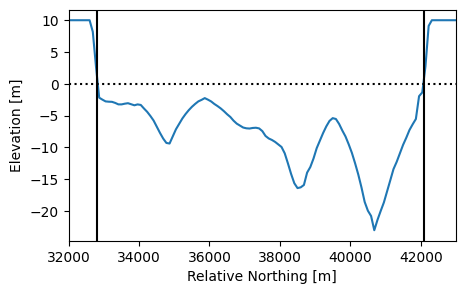

In [7]:
plt.figure(figsize=(5,3))
plt.plot(yp, zz[:,0])
plt.xlim(32000, 43000)
plt.axvline(32800, color='black')
plt.axvline(42100, color='black')
plt.axhline(0, color='black', linestyle=':')
plt.xlabel("Relative Northing [m]")
plt.ylabel("Elevation [m]")
plt.show()

Let's define the boundary condition from y = 32800 to 42100. That means...

In [8]:
bc_str = "BOUN SEGMENT XY 0 32800 0 42100 BTYPE WEAKrefl CON SERIes 'bc.txt' 7"

Now I need to prepare a time length for SWASH to run

In [9]:
model_time = 3600
hours, minutes, seconds = int(model_time/3600), int(model_time/60 - 60*int(model_time/3600)), model_time%60
timestr = "{hours:02d}{minutes:02d}{seconds:02d}.000".format(hours=hours, minutes=minutes, seconds=seconds)

Finally I will assert a template for 2D SWASH and inject the relevant components. Note only 1 vertical layer, which is probably ok considering I don't care about super accurate breaking physics. 

In [10]:
template = """
$
$*************** INPUT *********************
$
PROJ 'default' '01'
MODE NONSTationary TWODimensional
$
CGRID CURV {mxc} {myc}
READgrid COORdinates 1 'coords.txt' 1 0 0 FREE
VERT 1
INPgrid BOTtom CURV 
READinp BOTtom -1 'bathy.txt' 1 0 FREE
SET depmin = 0.010
SET level = 0
{bc_str}
$
$*************** PHYSICS *********************
$
FRIC MANN 0.019
SET BACKVISC 1.e-4
BREAK 0.6 0.3
VISC VERT KEPS
$
$*************** NUMERICS *********************
$
NONHYDROSTATIC BOX 1. PRECONDITIONER ILU
DISCRET CORRDEP MUSCL 
DISCRET UPW UMOM MOM VERT FIR
DISCRET UPW UMOM MOM HOR MUSCL
DISCRET UPW WMOM VERT FIR
DISCRET UPW WMOM HOR MUSCL
TIMEI 0.4 0.8
$
$
$************ OUTPUT REQUESTS *************************  
$
BLOCK 'COMPGRID' NOHEAD 'output.mat' XP YP BOTL WATL VKSIK VETAK HK OUTPUT 000000.000 1.0 SEC
TEST 1 0
COMPUTE 000000.000 0.01 SEC {timestr}
STOP
"""

ini_string = template.format(mxc=mxc, myc=myc, timestr=timestr, bc_str=bc_str)
input_file = open('INPUT', "w")
input_file.write(ini_string)
input_file.close()

### Basic SWASH Output
This part assumes the user then went and ran SWASH. For me, despite many concessions for speed, this simulation of 1 hour of waves took over 5 hours (on a beefy laptop). The first thing to do is to read out the matlab file and save it as a more reasonable filetype. 

In [11]:
# Load the matlab file
maf = 'output.mat'
m = scipy.io.loadmat(maf)

# Get x and y coordinates. 
x = np.unique(m['Xp'])
y = np.unique(m['Yp'])

# Get bed elevation
z_bottom = m['Botlev']

# Parse each key in the matlab file to grab the timestamp
t = []
for key_str in list(m.keys())[6:]:
    key_str_split = key_str.split('_')
    milliseconds = np.timedelta64( int(key_str_split[-1]),         'ms')
    seconds      = np.timedelta64( int(key_str_split[-2][-2:]),    's')
    minutes      = np.timedelta64( int(key_str_split[-2][-4:-2]),  'm')
    hours        = np.timedelta64( int(key_str_split[-2][-6:-4]),  'h')
    td = np.timedelta64(hours + minutes + seconds + milliseconds)
    t.append(td)

# Evaluate the unique values and use that as the available timesteps
t = np.unique(t)
t = np.array(t).astype('timedelta64[ms]')

# Only load the surface elevation timeseries (which is called 'Watlev')
# Read each key in the matlab file, classify and put in correct list
eta = []
for key_str in list(m.keys())[3:]:
    if 'Watlev' in key_str:
        eta.append(m[key_str])

# Write to a netcdf file
data_dict = {  'eta': (['t', 'y', 'x'], np.array(eta)),
             'z_bed': ([     'y', 'x'], z_bottom) }
coords_dict = {'x':x, 'y':y, 't':t}
out_ds = xr.Dataset(data_dict, coords=coords_dict)
out_ds.to_netcdf('output.nc')

/home/cassandra/anaconda3/envs/cht-sfincs/lib/python3.13/site-packages/scipy/io/matlab/_mio.py:235: MatReadWarning: Duplicate variable name "Xp" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/home/cassandra/anaconda3/envs/cht-sfincs/lib/python3.13/site-packages/scipy/io/matlab/_mio.py:235: MatReadWarning: Duplicate variable name "Yp" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/home/cassandra/anaconda3/envs/cht-sfincs/lib/python3.13/site-packages/scipy/io/matlab/_mio.py:235: MatReadWarning: Duplicate variable name "Botlev" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


Given the SWASH output, plot the significant wave height at each point, to show something about wave propagation. 

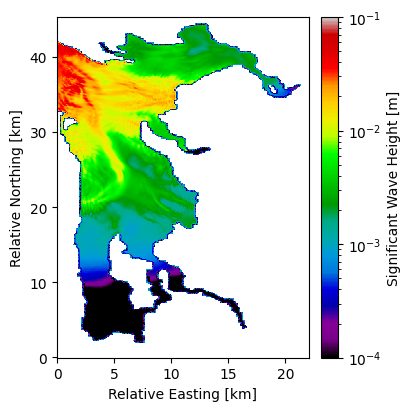

In [12]:
Hs = 4*np.std(out_ds.eta.values, axis=0)
Hs[out_ds.z_bed.values == -10] = np.nan
Hs[Hs <= 1e-8] = 1e-8

plt.figure(figsize=(4,4), constrained_layout=True)
cf = plt.pcolormesh(x/1000, y/1000, Hs, cmap='nipy_spectral', norm='log', shading='nearest', vmin=1e-4, vmax=1e-1)
cb = plt.colorbar(cf)
cb.ax.set_ylabel("Significant Wave Height [m]")
plt.xlabel("Relative Easting [km]")
plt.ylabel("Relative Northing [km]")
plt.show()

### Advanced SWASH Output - Resonant Modes
To get the resonant modes, I want to look at the spectrum at a few points in the bay, to see if any frequencies are elevated above baseline. I'll compare each to the spectrum of the boundary condition. First I'll load and plot the points around the bay, generated with https://geojson.io --

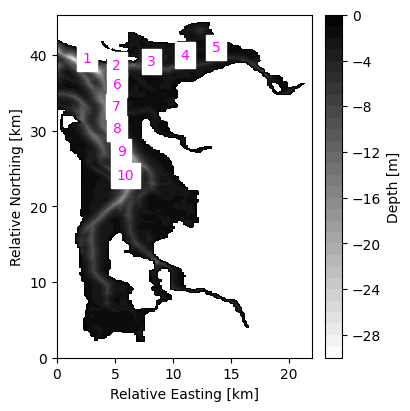

In [13]:
# Load the geojson file
import json
points_file = "../output_points.geojson"
js = json.load(open(points_file))

# Get latlon coordinates and convert to UTM
points_x, points_y = [], []
for point in js['features']:
    point_lon, point_lat = point['geometry']['coordinates']
    point_x, point_y, _, __ = utm.from_latlon(point_lat, point_lon)
    points_x.append(point_x)
    points_y.append(point_y)
points_x, points_y = np.array(points_x), np.array(points_y)

# Convert to problem coordinates
ppx, ppy = points_x - xrange[0], points_y - yrange[0]

# String number for each point to act as a label
num = [str(n) for n in range(1, len(points_x)+1)]

# Plot to show approx location of each point
plt.figure(figsize=(4,4), constrained_layout=True)
cf = plt.contourf(xp/1000, yp/1000, zz, levels=np.linspace(-30, 0, 31), cmap='binary')
cb = plt.colorbar(cf)
cb.ax.set_ylabel("Depth [m]")
for ppxx, ppyy, n in zip(ppx/1000, ppy/1000, num):
    plt.text(ppxx, ppyy, n, color='magenta', ma='center', backgroundcolor='white')
plt.xlabel("Relative Easting [km]")
plt.ylabel("Relative Northing [km]")
plt.show()

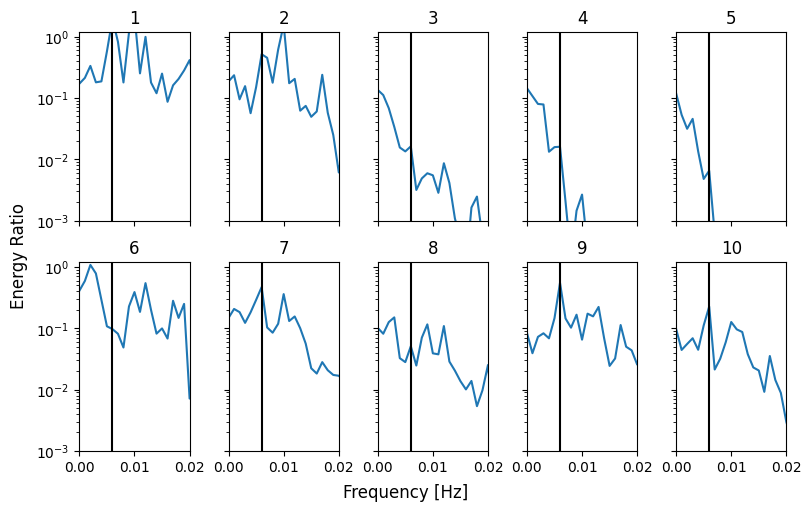

In [14]:
# Define some helper functions 
def cos_taper(a):
    x = np.linspace(-np.pi/2, np.pi/2, len(a))
    y = np.cos(x)
    tapered = y*a
    t_power = np.std(tapered)**2
    d_power = np.std(a)**2
    if d_power == 0: return a
    return tapered * d_power/t_power

def psd(a, dt=1.0, seg_time=1000):
    # segmenting
    seg_len = int(seg_time / dt)
    seg_indices = range(0, len(a) - int(seg_len), int(seg_len/2))
    seg_a = np.array([cos_taper(a[i:i+seg_len]) for i in seg_indices])
    # Evaluate frequency info
    freq = fftshift(fftfreq(seg_len, d=dt))
    df = freq[1] - freq[0]
    # FFT and go from amplitude to amp^2/Hz
    Fa = fftshift(fft(seg_a, axis=1), axes=1)
    Saa = np.real(np.nanmean((Fa * np.conj(Fa))/df, axis=0))
    # Drop negative frequencies
    Saa = 2*Saa[freq >= 0]
    freq = freq[freq >= 0]
    # Normalize energy
    ES = np.trapezoid(Saa, x=freq)
    Ea = np.std(a)**2
    Saa = Saa * Ea/ES
    return freq, Saa

# Get boundary spectrum
freq, bound_spec = psd(a)

# But assume its flat, for purposes of argument...
bound_spec = np.ones(len(freq))*np.nanmean(bound_spec[freq<0.02])

# Plot spectra for each point
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(8,5),
                        sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten()
for i, ppxx, ppyy, n in zip(range(len(num)), ppx, ppy, num):
    xi, yi = np.argmin(np.abs(x - ppxx)), np.argmin(np.abs(y-ppyy))
    point_eta = out_ds.eta[:,yi,xi].values
    freq, spec = psd(point_eta)
    axs[i].set_title(n)
    axs[i].plot(freq, spec/bound_spec)
    #axs[i].plot(freq, bound_spec, color='black')
    axs[i].axvline(0.006, color='black')
#plt.loglog()
plt.xlim(0, 0.02)
plt.yscale('log')
plt.ylim(1e-3, 1.2)
fig.supxlabel("Frequency [Hz]")
fig.supylabel("Energy Ratio")
plt.show()

I'm comparing the incident wave energy to the energy at each point, as a ratio. I'm interested in the frequencies that have a larger response, suggesting the possible presence of a seiche mode. I'll focus on f = 0.006 Hz (marked as a solid line), which appears to be a possible mode. The last analysis step will be to bandpass the time series for this frequency in particular, and plot the associated significant wave height spatially. If there are nodes and antinodes, it may suggest a normal mode. 

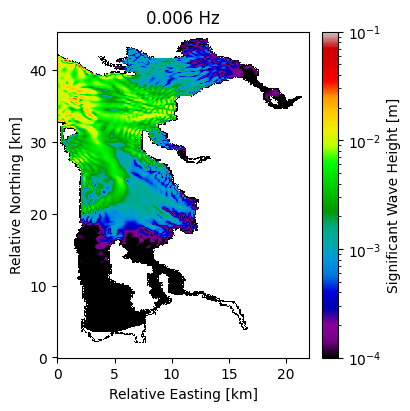

In [15]:
# Define frequency of interest
df = freq[1] - freq[0]
f = 0.006

# Function to bandpass a time series
def freq_pass(a, f0, f1, dt=1.0):
    freq = fftfreq(len(a), d=dt)
    freq_ok = np.logical_and(np.abs(freq) >= f0, np.abs(freq) <= f1)
    F_a = fft(a)
    F_a[~freq_ok] = 0 
    a_pass = np.real(ifft(F_a))
    a_pass = a_pass + np.nanmedian(a)
    return a_pass

# Band pass at each point around frequency of interest
eta_passed = []
for xi in range(len(x)):
    eta_passed.append([])
    for yi in range(len(y)):
        point_eta = out_ds.eta[:,yi,xi].values
        eta_passed[-1].append(freq_pass(point_eta, f - df/2, f + df/2))

# Compute significant wave height
Hsf = 4*np.std(eta_passed, axis=2)
Hsf[out_ds.z_bed.values.T == -10] = np.nan

# Plot
plt.figure(figsize=(4,4), constrained_layout=True)
cf = plt.pcolormesh(x/1000, y/1000, Hsf.T, cmap='nipy_spectral', norm='log', shading='nearest', vmin=1e-4, vmax=1e-1)
cb = plt.colorbar(cf)
cb.ax.set_ylabel("Significant Wave Height [m]")
plt.xlabel("Relative Easting [km]")
plt.ylabel("Relative Northing [km]")
plt.title(str(f)+ " Hz")
plt.show()

### EOFs - Empirical Orthogonal Functions
It may be the pure significant wave height cannot resolve mode shapes, owing to progressive waves diluting the signal. For a quick analysis, EOFs may succeed where bandpassed significant wave height failed. 

In [27]:
import scipy

# To prepare to compute eigenvalues, need to flatten spatial dimensions and drop all NANs
eta_passed = np.array(eta_passed)
eta_flattened = eta_passed.reshape((len(x)*len(y), len(t)))
eta_passed[eta_passed >= 10] = np.nan # Drop dry values
nan_ok = np.sum(np.isnan(eta_flattened), axis=1) == 0

# Also reduce the accuracy, for speed
eta_flattened = eta_flattened.astype(np.float32)

In [29]:
# Singular value decomposition
U, s, Vh = scipy.linalg.svd(eta_flattened[nan_ok], full_matrices=False, check_finite=False)

In [ ]:
# Reshape U from shape [de-nan'd len(x)*len(y), t] to [x,y,t]
# note the t dimension refers not to time but to EOF number
U_flattened = np.ones(eta_flattened.shape)*np.nan
U_flattened[nan_ok] = U
U_shaped = U_flattened.reshape((len(x), len(y), len(t)))

In [60]:
# Compute power from the SVDs
s_total = np.nansum(s[1:]**2) # Skip the first one, its just the average
s_relative = s**2 / s_total

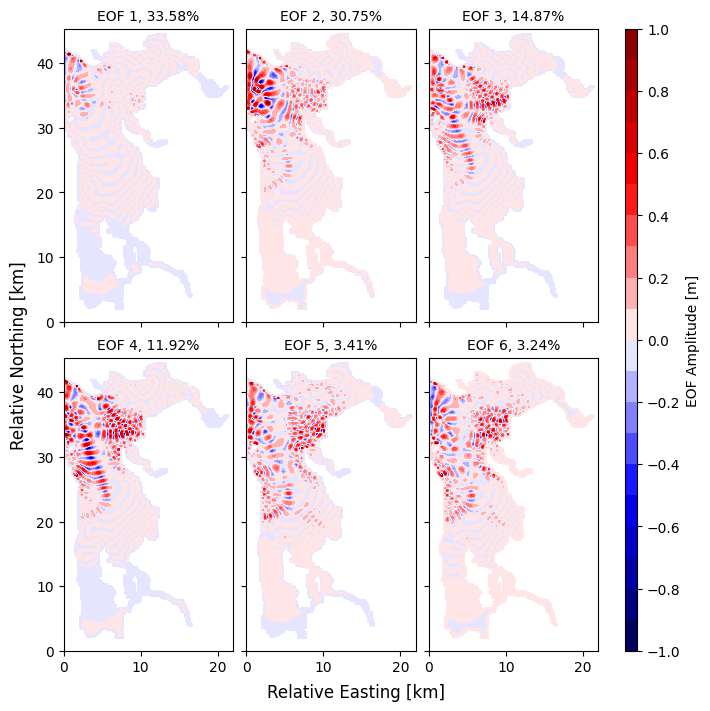

In [80]:
# Plot the first few EOFs
fig, axs = plt.subplots(ncols=3, nrows=2, sharex=True, sharey=True, constrained_layout=True, figsize=(7,7))
for i, ax in enumerate(axs.flatten()):
    EOF = U_shaped[:,:,i+1].T # Skip the first one (its just the average)
    EOF = EOF / np.nanmax(EOF)
    cf = ax.contourf(x/1000, y/1000, EOF, cmap='seismic', levels=np.linspace(-1, 1, 21))
    ax.set_title("EOF " + str(i+1) + ", " + str(np.around(100*s_relative[i+1], 2)) + "%", fontsize=10)
cb = plt.colorbar(cf, ax=axs, aspect=50, ticks=np.linspace(-1, 1, 11))
cb.ax.set_ylabel("EOF Amplitude [m]")
fig.supxlabel("Relative Easting [km]")
fig.supylabel("Relative Northing [km]")
plt.show()

The EOFs are dominated by progressive waves along the channel. This analysis seems unable to resolve any seiche-like modes for this frequency, except perhaps at the very ends of the channel. 

### Conclusions
I tentatively conclude this test should be run with lower frequency waves, and that it may be possible (as others have pointed out) that the low seiche modes of the estuary are not in the infragravity band. I believe further analysis should start with the low modes and move up from there. 